# Playing with contours


The `contour_2d` class can represents a graph cut in a 2D image as a set of polylines separating regions. The precision of each polyline can be adjusted in order to have a precise or a simplified representation of the real contours.

This notebook is going to demonstrate the basic usage of `Contour2d` related functions. We are going to:

1. Compute the watershed cut of an image;
2. Represent the cut as a `Contour2d` object using the `fit_contour_2d` function and iterate over all segments of a `Contour2d` object in order to draw them;
3. Refine a `Contour2d` object using the `subdivide` method and explore the influence of the parameters of the method.

## Watershed cut of an image

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import higra as hg

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

We process a classical image from BSDS.

Image size: (321, 481)


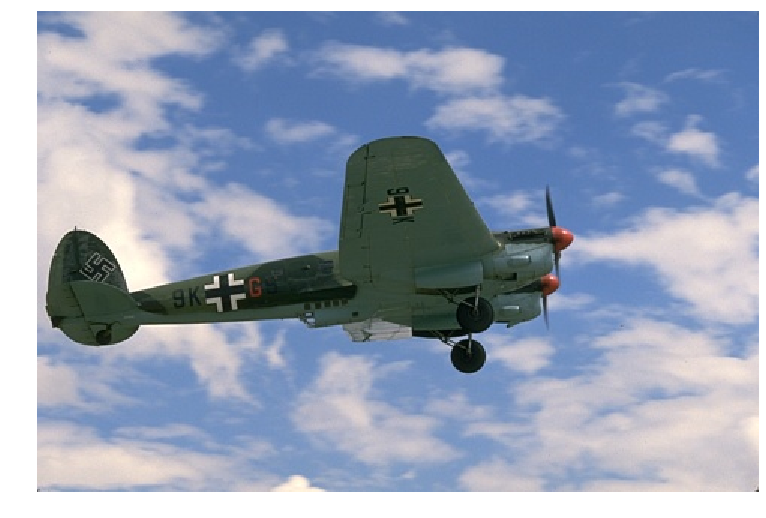

(<Figure size 721.5x481.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fc22523dd30>)

In [3]:
image = imageio.imread(locate_resource("3063.ppm"))
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float32)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

In order to compute a cut in this image, we will use a high quality gradient : the Structured Edge Detector https://github.com/pdollar/edges

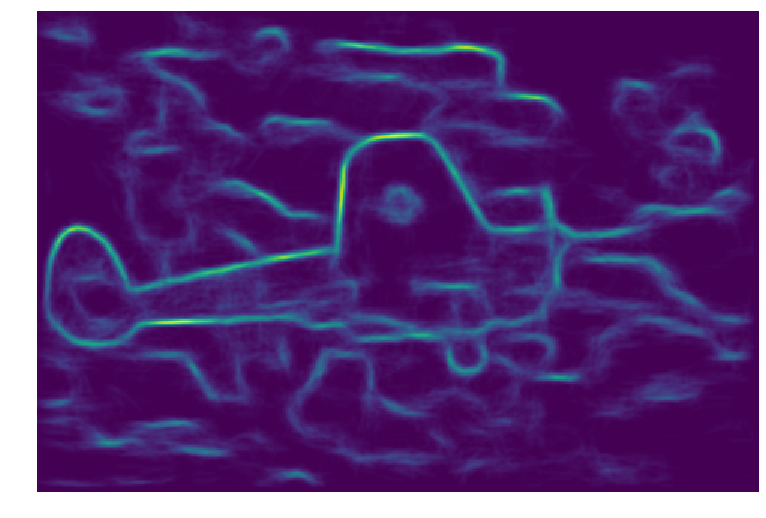

(<Figure size 721.5x481.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fc2251c3dd8>)

In [4]:
detector = cv2.ximgproc.createStructuredEdgeDetection(get_sed_model_file())
gradient_image = detector.detectEdges(image)

imshow(gradient_image)

Finally, we can compute a watershed cut from this gradient:

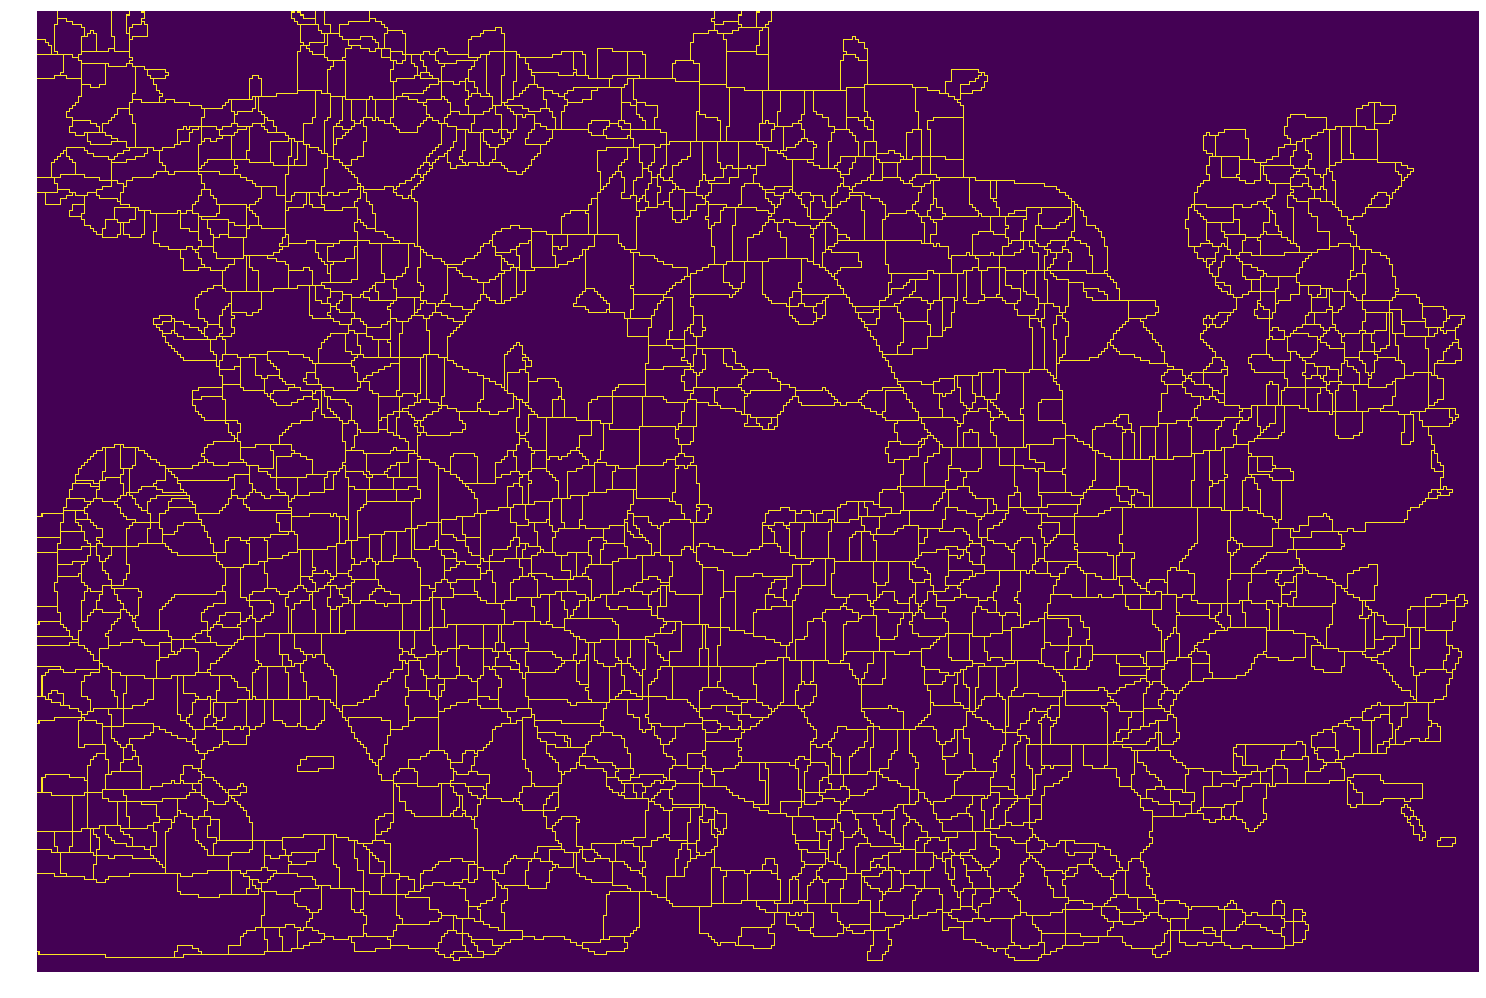

(<Figure size 1441.5x961.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fc225135b00>)

In [5]:
# first we will transfer the gradient_image computed on pixels to edge weights on a 4 adjacency graph
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image, hg.WeightFunction.mean)

# then compute the pixel labelisation into watershed basins
labelisation = hg.labelisation_watershed(graph, edge_weights)

# finally, the cut is composed of edges linking two regions with different labels 
watershed_cut = hg.weight_graph(graph, labelisation, hg.WeightFunction.L0)

# we can visualize the result in the Khalimsky grid
watershed_cut_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, watershed_cut)
imshow(watershed_cut_khalimsky)

## The `Contour2d` object

A `Contour2d` represents a graph in a 2d image by using geometric primitives (basically line segments).

A `Contour2d` object is obtained from a graph cut with the `fit_contour_2d` function. This function takes 3 parameters: the graph (must be a 4 adjacency graph), the size of the image ( (height, width) ), and the edge weights (edges with non zero weights belongs to the cut).

We are going to visualize `Contour2d` objects by drawings each segment of the contour. For this, we first need to understand how the composition of a`Contour2d` object.
A `Contour2d` is a set of polylines and each polyline represent a continuous piece of contour between two regions of a cut. 
A polyline is itself composed of a sequence of line segments.
A segment is composed of a sequence of pairs of elements (ei, p) where ei is the edge_index of the element and p is its 2d coordinates.
Consecutive segments of a given polyline share the same first/last elements. 


We are first going to define the function `draw_contour` which iterated on every segment of a `Contour2d` and draw it on an image:

In [6]:
from PIL import Image, ImageDraw

def draw_contour(contour, size):
    # define a drawing buffer
    image = np.zeros(size, np.uint8) + 255
    image_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(image_pil)

    for polyline in contour: # for each poyline in the contour
        for segment in polyline: # for each segment in the polyline
            p1 = segment[0][1] # coordinates of the first element of the segment
            p2 = segment[len(segment) - 1][1] # coordinates of the last element of the segment
            draw.line((p1[1],p1[0],p2[1],p2[0]), fill=0) # draw the segment
        
    del draw
    return  np.array(image_pil)
    

By applying this function to the result of the `fit_contour_2d` function, we see that the each polyline of the fitted contour initially contains a single segment: it is thus a rough geometric approximation of the cut:

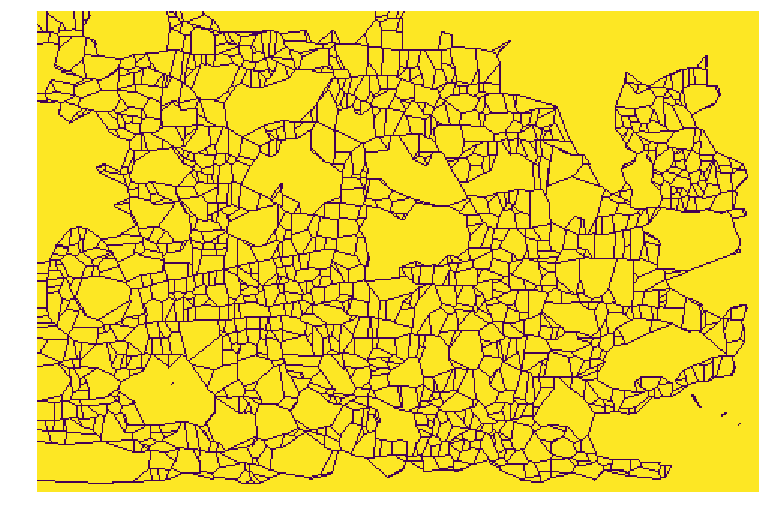

(<Figure size 721.5x481.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fc225144208>)

In [7]:
contours = hg.fit_contour_2d(graph, size, watershed_cut)
result = draw_contour(contours, size)
imshow(result)

## Subdividing the segments of a `Contour2d` object

The geometric approximation given by the `Contour2d` object can be refined thanks to the `subdivide` function which implements the Ramer–Douglas–Peucker algorithm for polyline simplification/subdivision.

The `subdivide` function has two important parameters `epsilon` and `min_size`. Each poyline of the contour will be recursively subdivided until the following condition holds true. For each segment of the polyline, the distance between the straight line joining the extremities of the segment and each of its elements is smaller than `epsilon` times the distance between the segment extremities, or smaller than the minimal specified size `min_size`.

For example, setting both `epsilon` and `min_size` to 0 will perform a maximal subdivision (only perfectly straight segments are not subdivided):
        

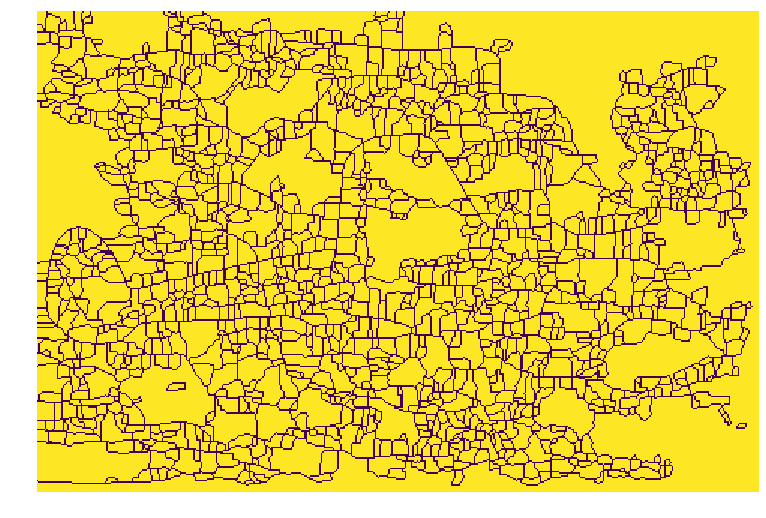

(<Figure size 721.5x481.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fc225071da0>)

In [8]:
contours = hg.fit_contour_2d(graph, size, watershed_cut)
contours.subdivide(epsilon=0, min_size=0)
test = draw_contour(contours, size)
imshow(test)

Hopefully, default parameters shoudl do the trick in most situations. The effect of each parameter can be experienced in the following interractive example:

In [9]:
from ipywidgets import  interact, widgets, IntSlider, FloatSlider

def simplify_contours(epsilon, min_size):
    contours = hg.fit_contour_2d(graph, size, watershed_cut)
    contours.subdivide(epsilon=epsilon, min_size=min_size)
    test = draw_contour(contours, size)
    imshow(test)
    
interact(simplify_contours, 
         epsilon=FloatSlider(value=0.1, min=0, max=1, step=0.025, continuous_update=False),
         min_size=IntSlider(value=2, min=0, max=20, step=1, continuous_update=False));

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='epsilon', max=1.0, step=0.0…